In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns

import delfi
from delfi.simulator.BaseSimulator import BaseSimulator
from delfi.inference import SNPE
import delfi.distribution as dd
from delfi.summarystats import Identity
from delfi.summarystats.BaseSummaryStats import BaseSummaryStats
from delfi.generator import Default
from delfi.generator import MPGenerator

import models as md

In [96]:
fit_df = pd.read_hdf('../data/generated/fitting_validation_error_v4.hdf5', key='fitting_results')
fit_df2 = pd.read_hdf('../data/generated/fitting_validation_error_v3.hdf5', key='fitting_results')

In [97]:
fit_df2.keys()

Index(['final_loss', 'logs_list', 'mean_noise_std_exc', 'mean_rho_null',
       'mean_rho_null_std', 'mean_rho_scale', 'posterior_object',
       'std_noise_std_exc', 'std_rho_null', 'std_rho_null_std',
       'std_rho_scale', 'true_noise_std_exc', 'true_rho_null',
       'true_rho_null_std', 'true_rho_scale'],
      dtype='object')

In [100]:
fit_df = fit_df.append(fit_df2, ignore_index=True)

In [101]:
len(fit_df)

10

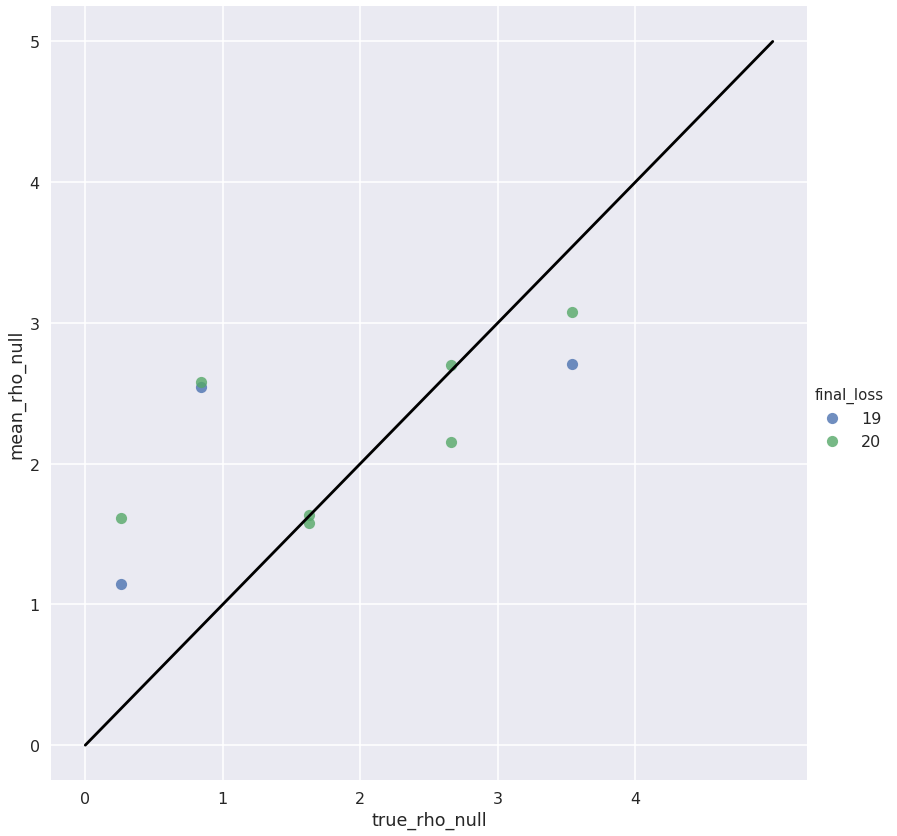

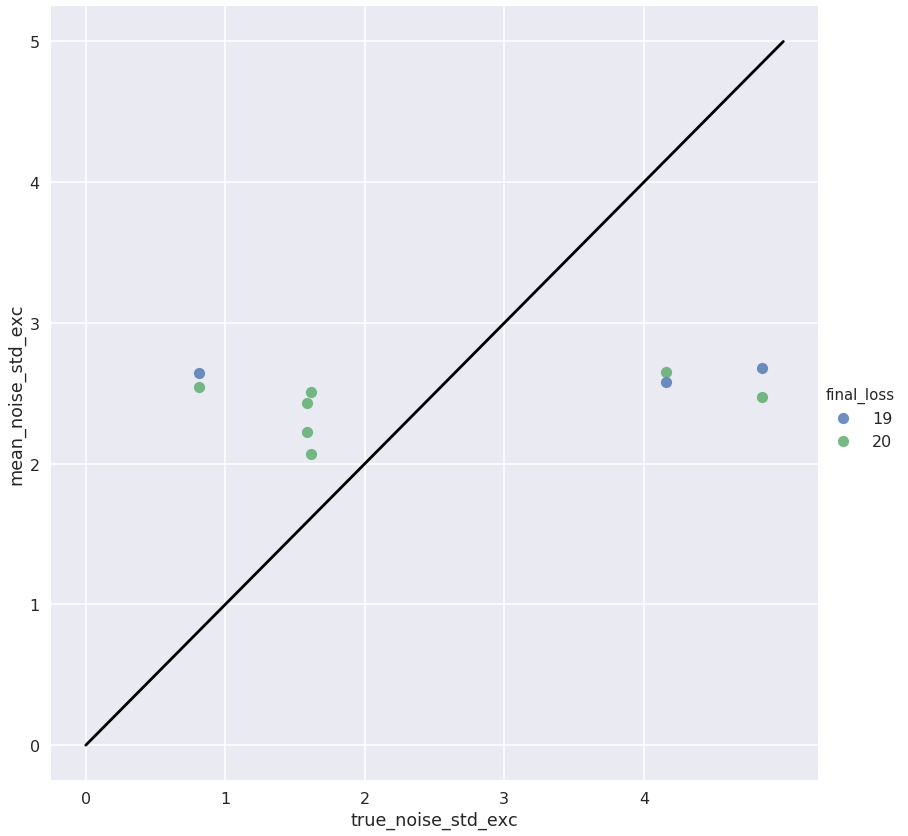

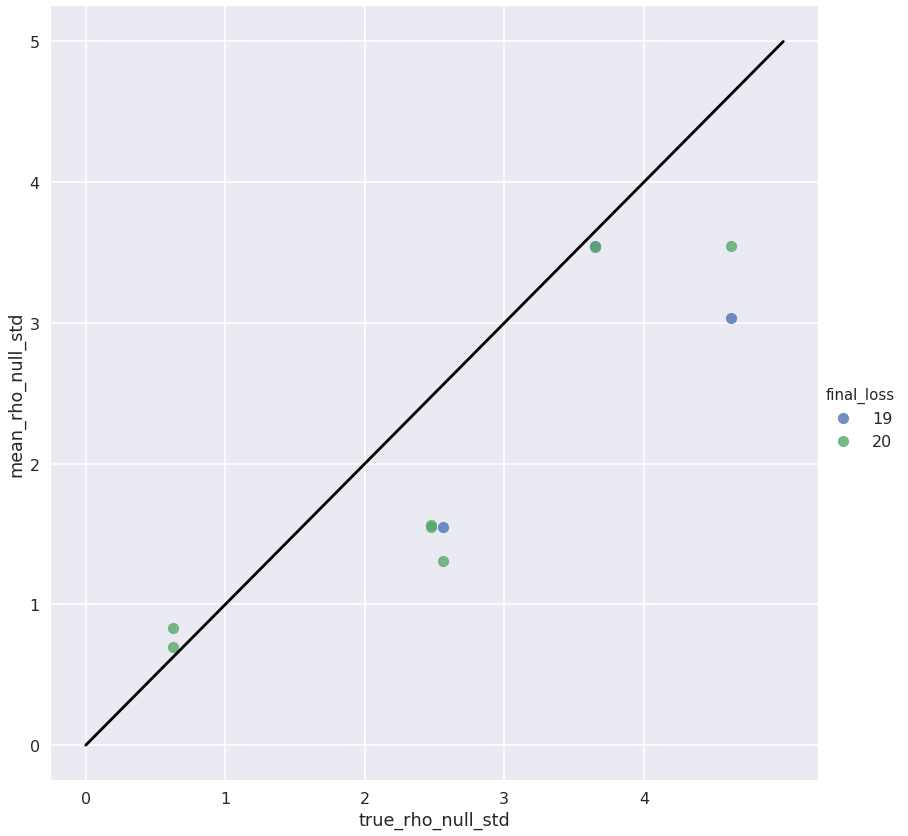

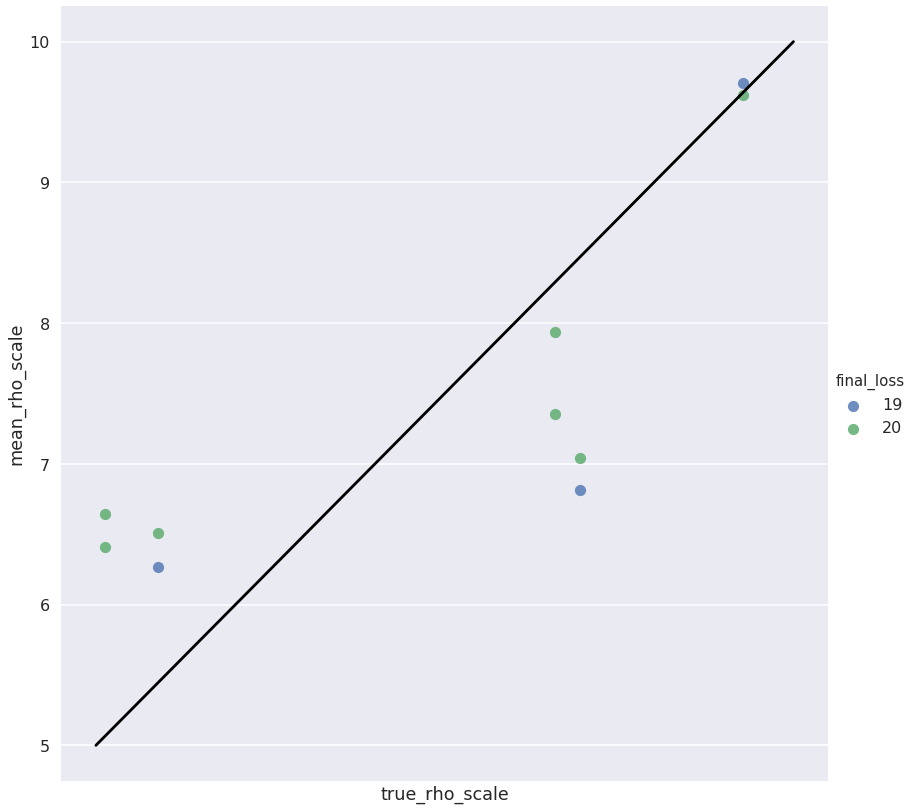

In [102]:
sns.set('poster')

sns.lmplot(x='true_rho_null', y='mean_rho_null', hue='final_loss', data=fit_df, fit_reg=False, size=12)
plt.xticks(np.arange(5), np.arange(5))
plt.plot([0, 5], [0,5], 'k')

sns.lmplot(x='true_noise_std_exc', y='mean_noise_std_exc', hue='final_loss', data=fit_df, fit_reg=False, size=12)
plt.xticks(np.arange(5), np.arange(5))
plt.plot([0, 5], [0,5], 'k')

sns.lmplot(x='true_rho_null_std', y='mean_rho_null_std', hue='final_loss', data=fit_df, fit_reg=False, size=12)
plt.xticks(np.arange(5), np.arange(5))
plt.plot([0, 5], [0,5], 'k')

sns.lmplot(x='true_rho_scale', y='mean_rho_scale', hue='final_loss', data=fit_df, fit_reg=False, size=12)
plt.xticks(np.arange(5), np.arange(5))
plt.plot([5, 10], [5, 10], 'k')

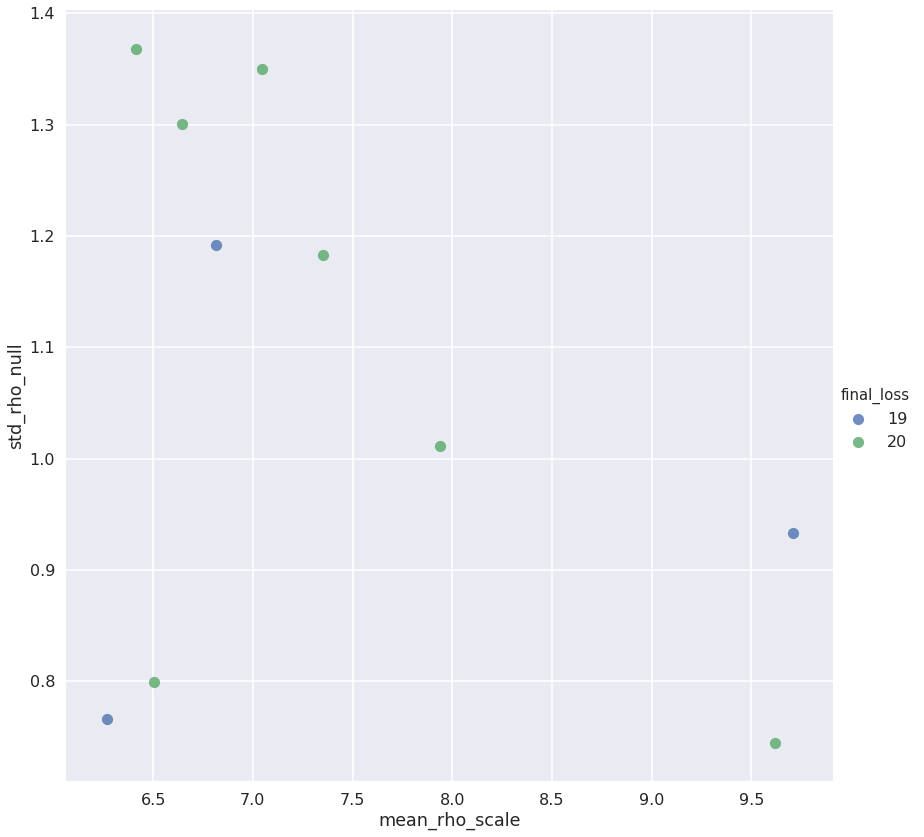

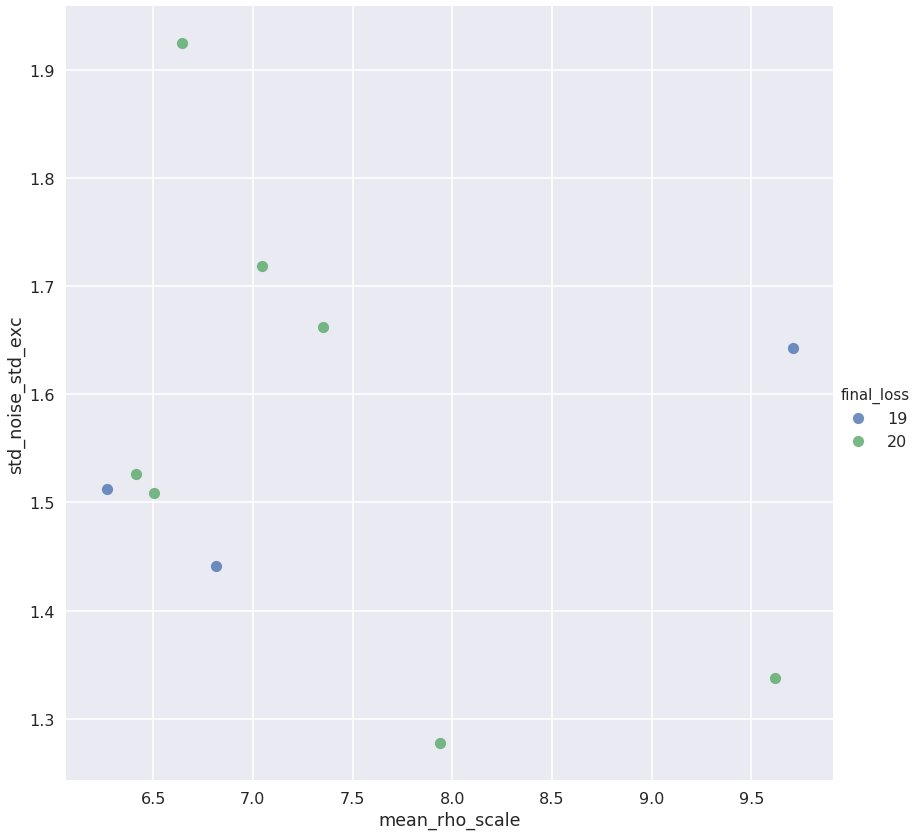

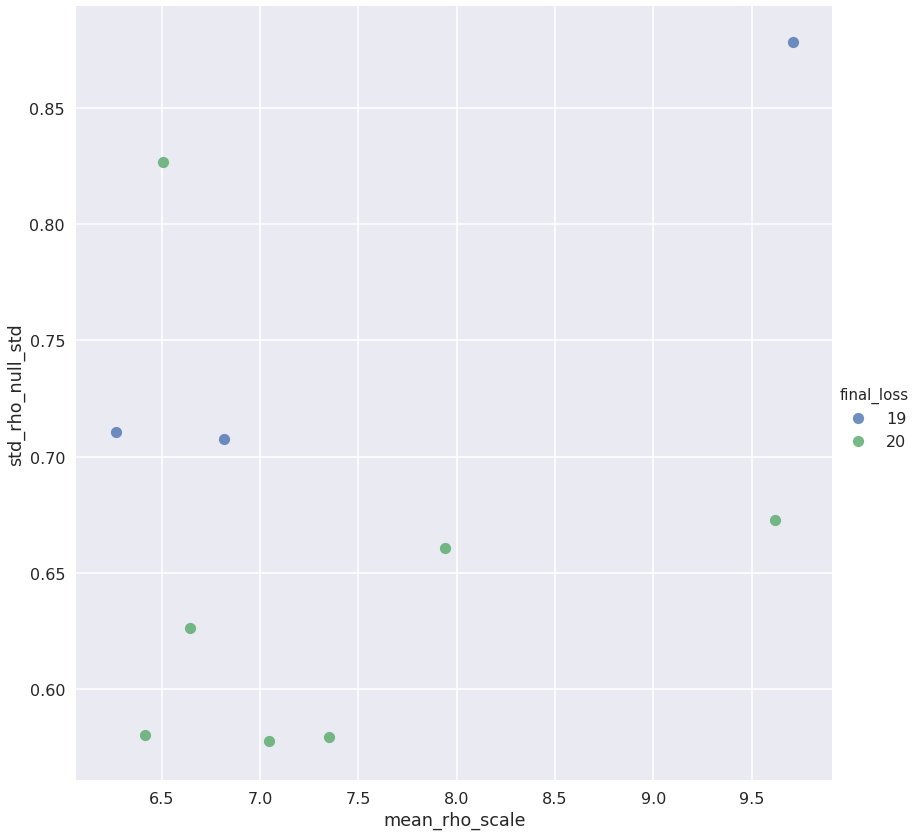

In [103]:
sns.set('poster')

sns.lmplot(x='mean_rho_scale', y='std_rho_null', hue='final_loss', data=fit_df, fit_reg=False, size=12)
#plt.xticks(np.arange(5), np.arange(5))
#plt.plot([0, 5], [0,5], 'k')

sns.lmplot(x='mean_rho_scale', y='std_noise_std_exc', hue='final_loss', data=fit_df, fit_reg=False, size=12)
#plt.xticks(np.arange(5), np.arange(5))
#plt.plot([0, 5], [0,5], 'k')

sns.lmplot(x='mean_rho_scale', y='std_rho_null_std', hue='final_loss', data=fit_df, fit_reg=False, size=12)
#plt.xticks(np.arange(5), np.arange(5))
#plt.plot([0, 5], [0,5], 'k')

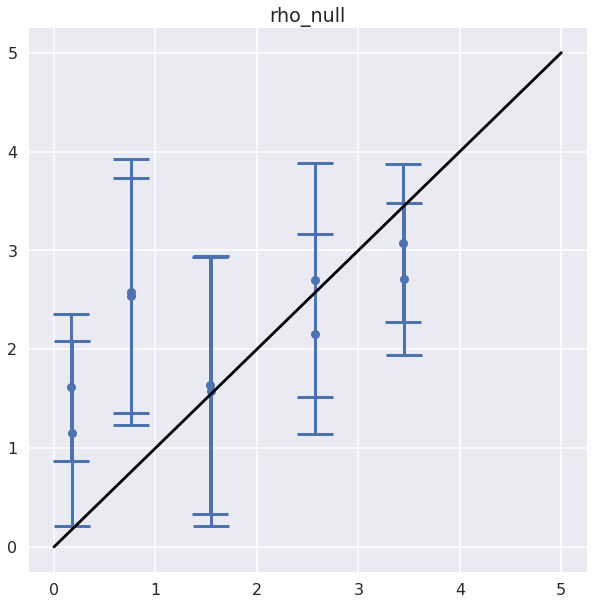

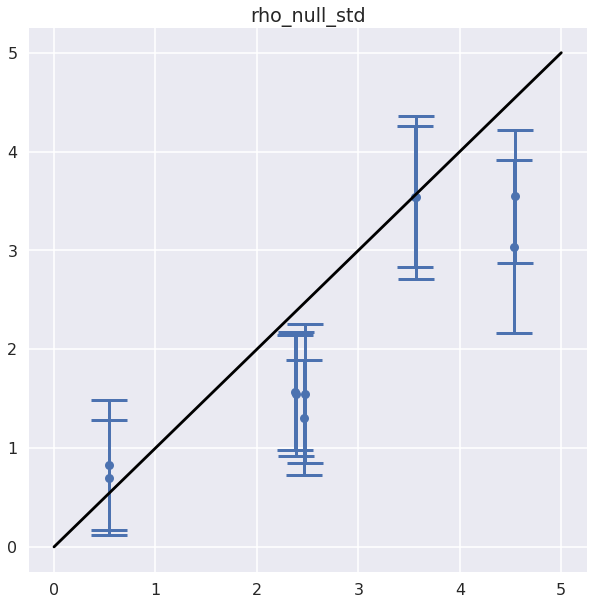

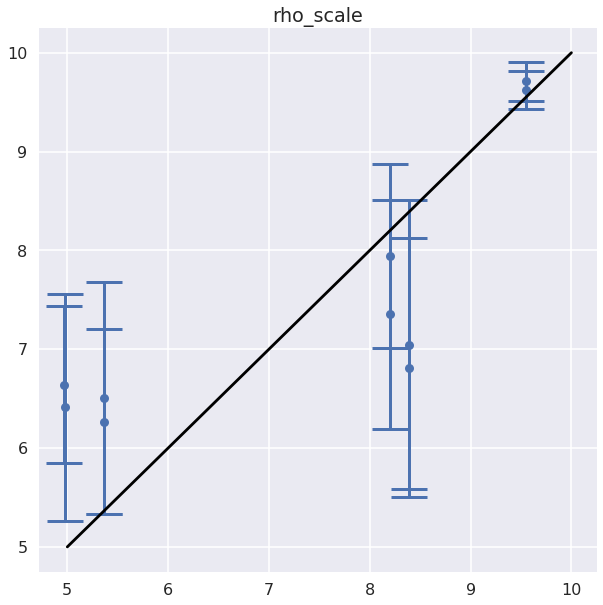

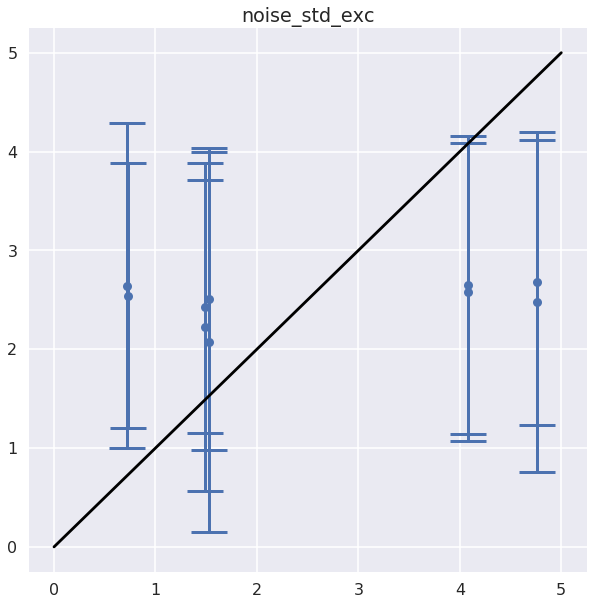

In [105]:
def plot_true_vs_estimate(param_name, xmin=0, xmax=5):
    jitter = np.random.rand(len(fit_df))*0.02 - 0.1
    plt.figure(figsize=(10,10))
    plt.errorbar(fit_df['true_' + param_name] + jitter, fit_df['mean_' + param_name], yerr=fit_df['std_' + param_name],
                 fmt='.', capsize=18, barsabove=True, capthick=3, lw=3, ms=18)
    plt.plot([xmin, xmax], [xmin, xmax], 'k')
    plt.title(param_name)
    
plot_true_vs_estimate('rho_null')
plot_true_vs_estimate('rho_null_std')
plot_true_vs_estimate('rho_scale', xmin=5, xmax=10)
plot_true_vs_estimate('noise_std_exc')

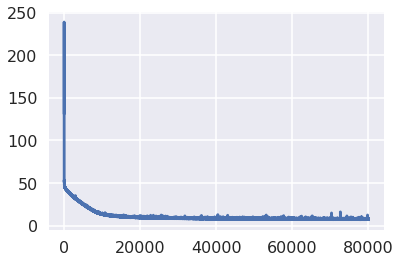

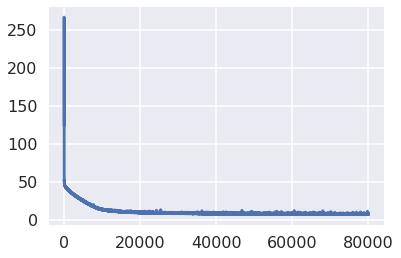

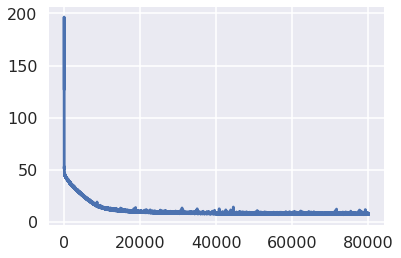

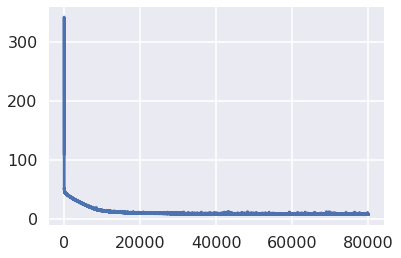

In [87]:
for i in range(len(fit_df)):
    plt.figure()
    plt.plot(fit_df['logs_list'][i][0]['loss'])

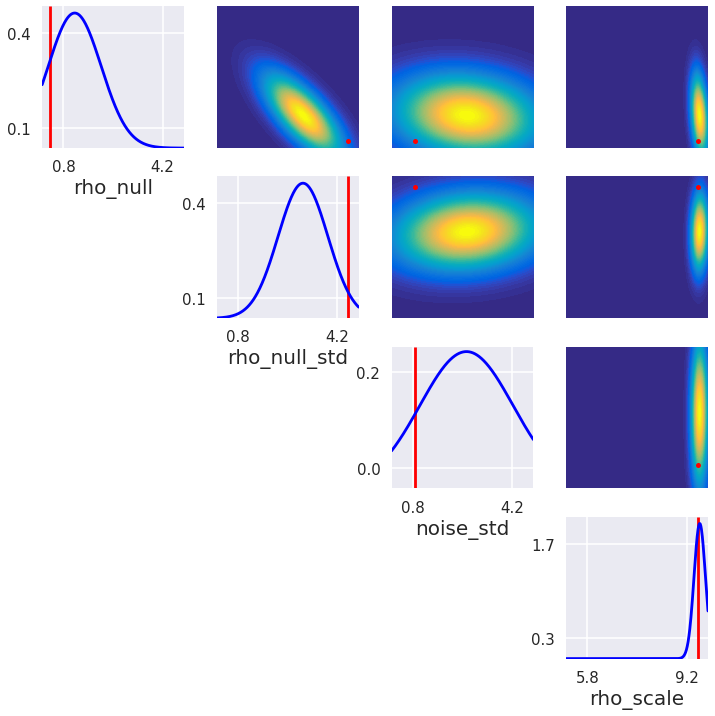

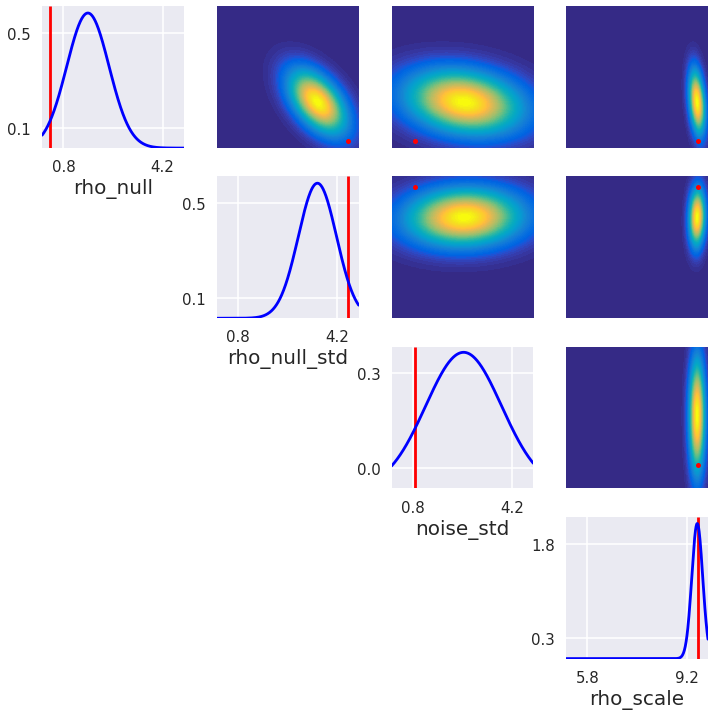

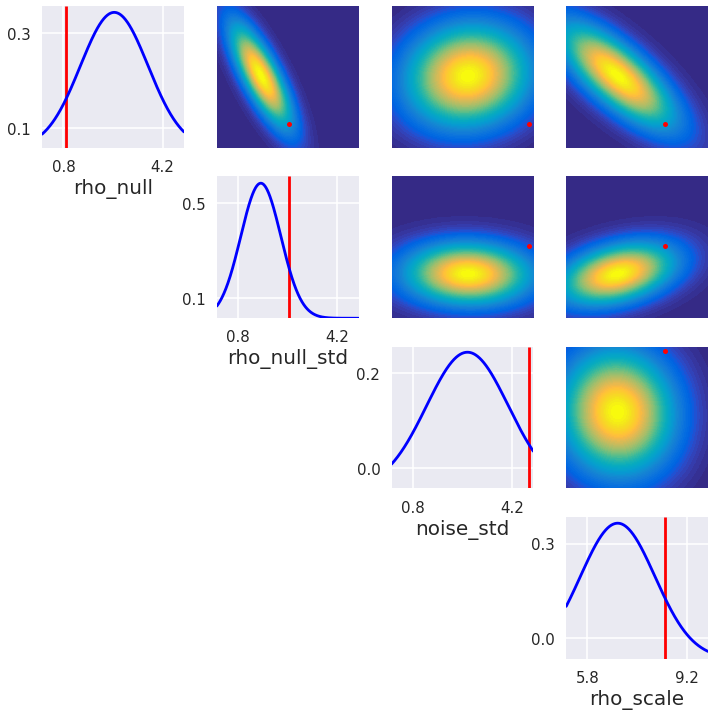

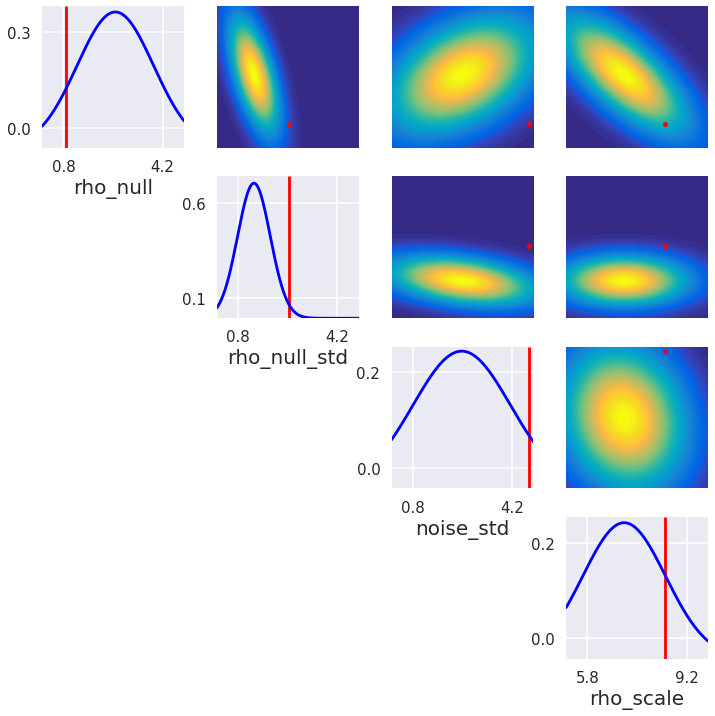

In [90]:
for i in range(len(fit_df)):
    cpst = fit_df['posterior_object'][i]
    lims = np.array([[0, 5],[0, 5], [0, 5], [5, 10]])
    gt_array = [fit_df['true_rho_null'][i], fit_df['true_rho_null_std'][i], fit_df['true_noise_std_exc'][i], fit_df['true_rho_scale'][i]]
    viz.plot_pdf(cpst.xs[0], lims=lims, labels_params=['rho_null', 'rho_null_std', 'noise_std', 'rho_scale'],
                 gt=gt_array, figsize=(12,12), ticks=True)

# Meta-parameter exploration

In [61]:
meta_df = pd.read_hdf('../data/generated/fitting_metaparams_exploration_v3.hdf5', key='fitting_results')
true_params = pd.read_hdf('../data/generated/fitting_metaparams_exploration_v3.hdf5', key='ground_truth_params')

In [62]:
meta_df.keys()

Index(['final_loss', 'logs_list', 'mean_noise_std_exc', 'mean_rho_null',
       'mean_rho_null_std', 'mean_rho_scale', 'n_hidden', 'n_rounds',
       'n_train', 'posterior_object', 'std_noise_std_exc', 'std_rho_null',
       'std_rho_null_std', 'std_rho_scale'],
      dtype='object')

In [64]:
meta_df['error_rho_scale'] = np.array(meta_df['mean_rho_scale']) - np.array(true_params['rho_scale'])
meta_df['error_rho_null'] = np.array(meta_df['mean_rho_null']) - np.array(true_params['rho_null'])
meta_df['error_rho_null_std'] = np.array(meta_df['mean_rho_null_std']) - np.array(true_params['rho_null_std'])
meta_df['error_noise_std_exc'] = np.array(meta_df['mean_noise_std_exc']) - np.array(true_params['noise_std_exc'])

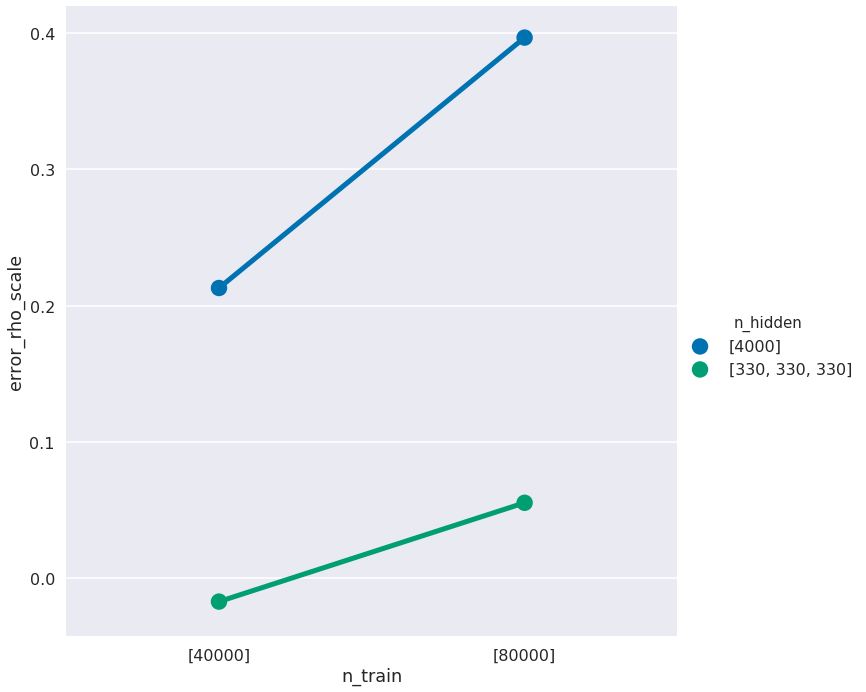

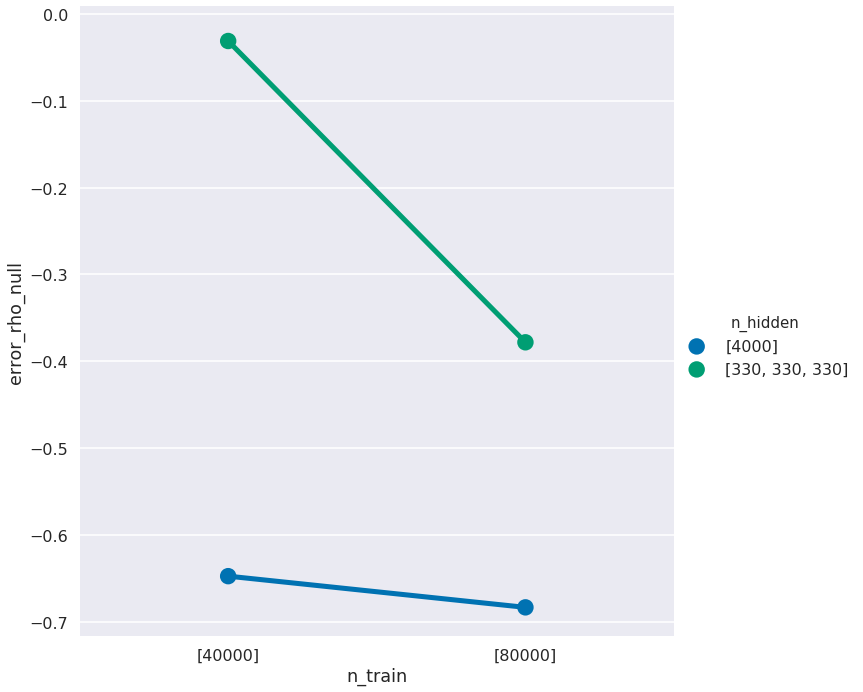

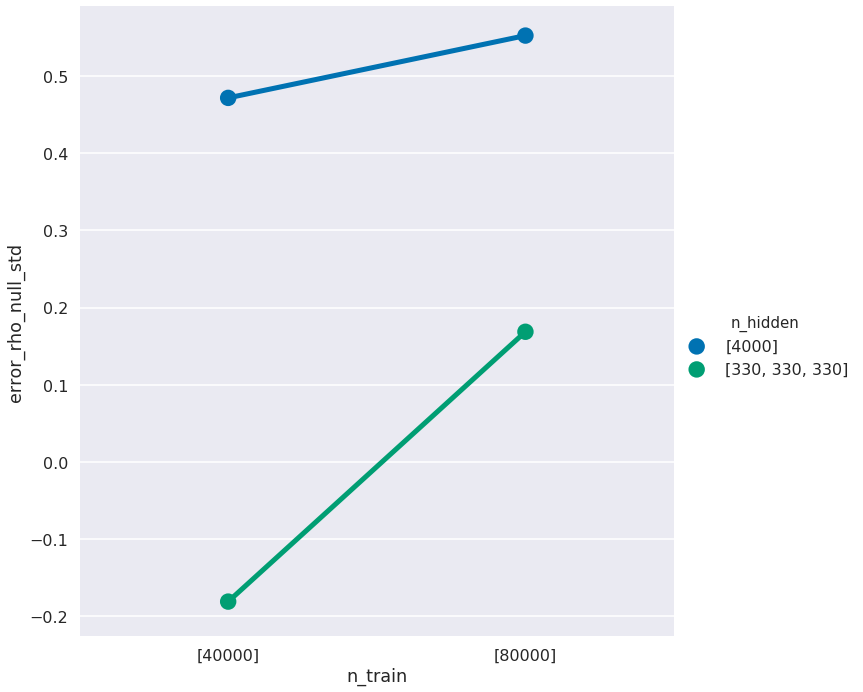

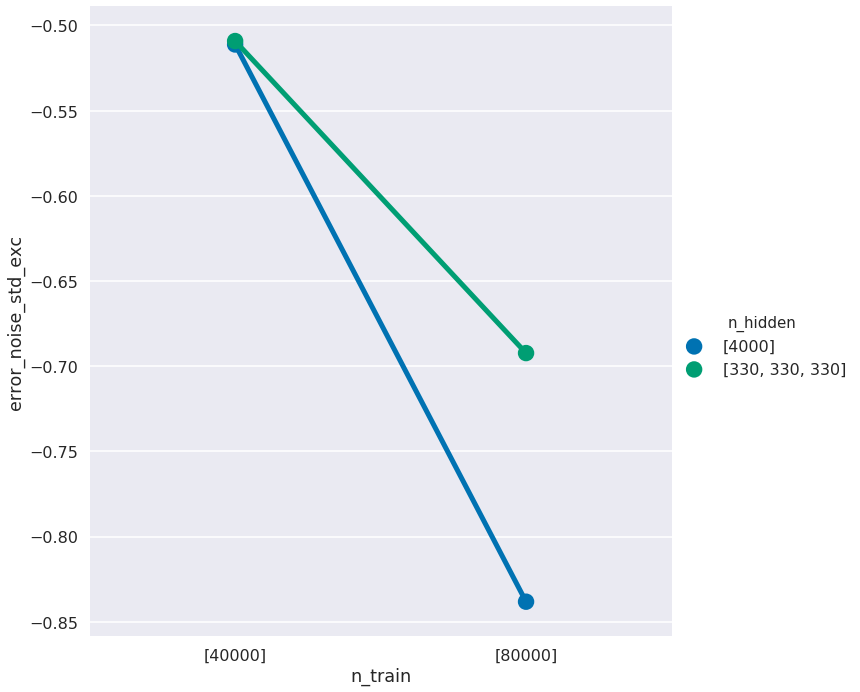

In [65]:
sns.factorplot(x='n_train', y='error_rho_scale', hue='n_hidden', kind='point', data=meta_df, size=10)
sns.factorplot(x='n_train', y='error_rho_null', hue='n_hidden', kind='point', data=meta_df, size=10)
sns.factorplot(x='n_train', y='error_rho_null_std', hue='n_hidden', kind='point', data=meta_df, size=10)
sns.factorplot(x='n_train', y='error_noise_std_exc', hue='n_hidden', kind='point', data=meta_df, size=10)

In [66]:
np.array(meta_df['mean_noise_std_exc'])

array([2.68569861, 2.35861557, 2.68772092, 2.5045557 ])

In [63]:
true_params

,noise_std_exc,rho_null,rho_null_std,rho_scale
0,3.196885,3.660417,2.085101,8.261901


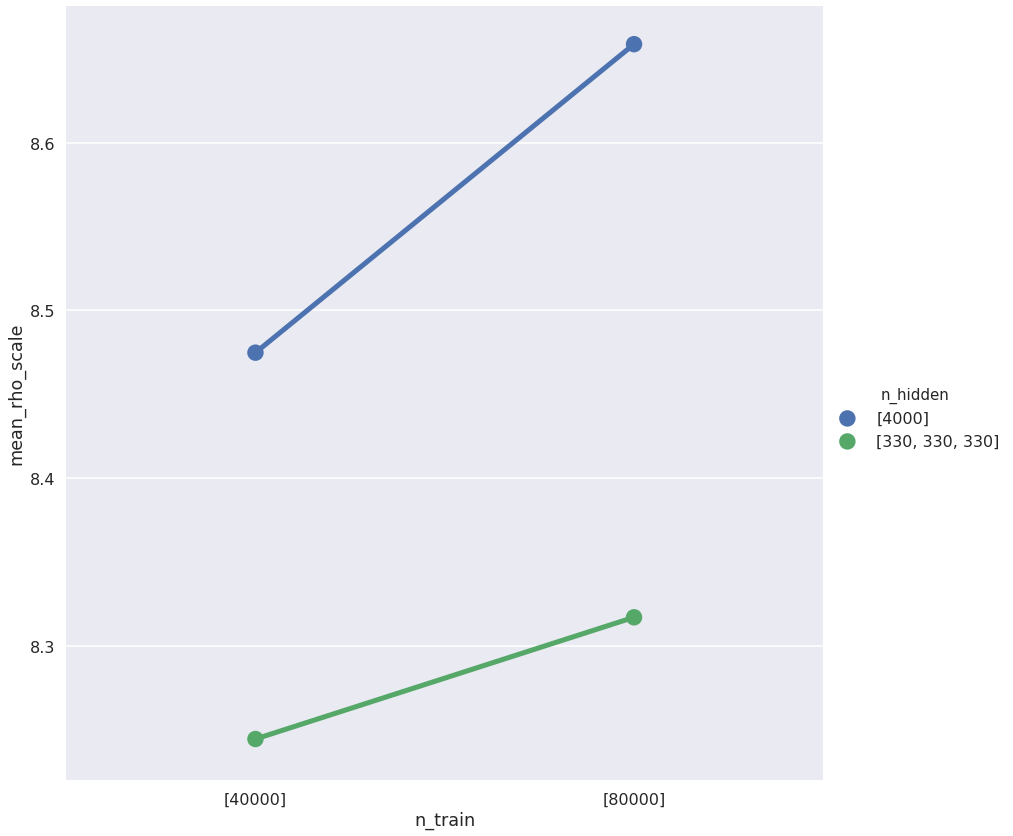

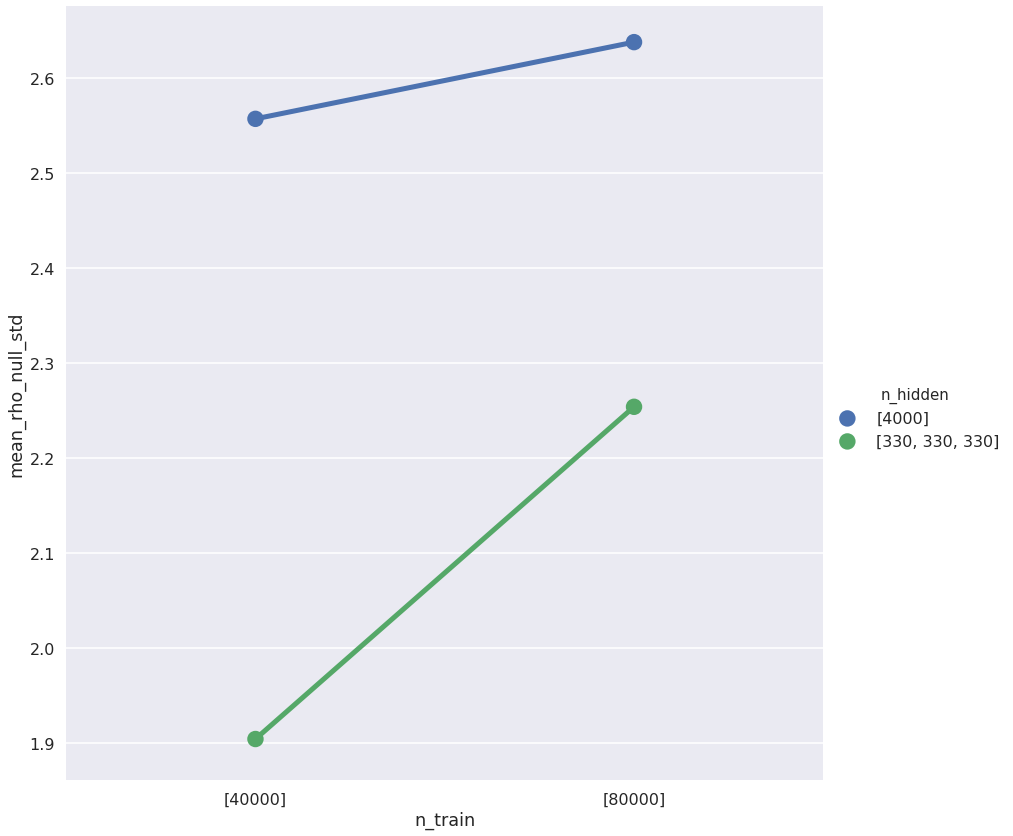

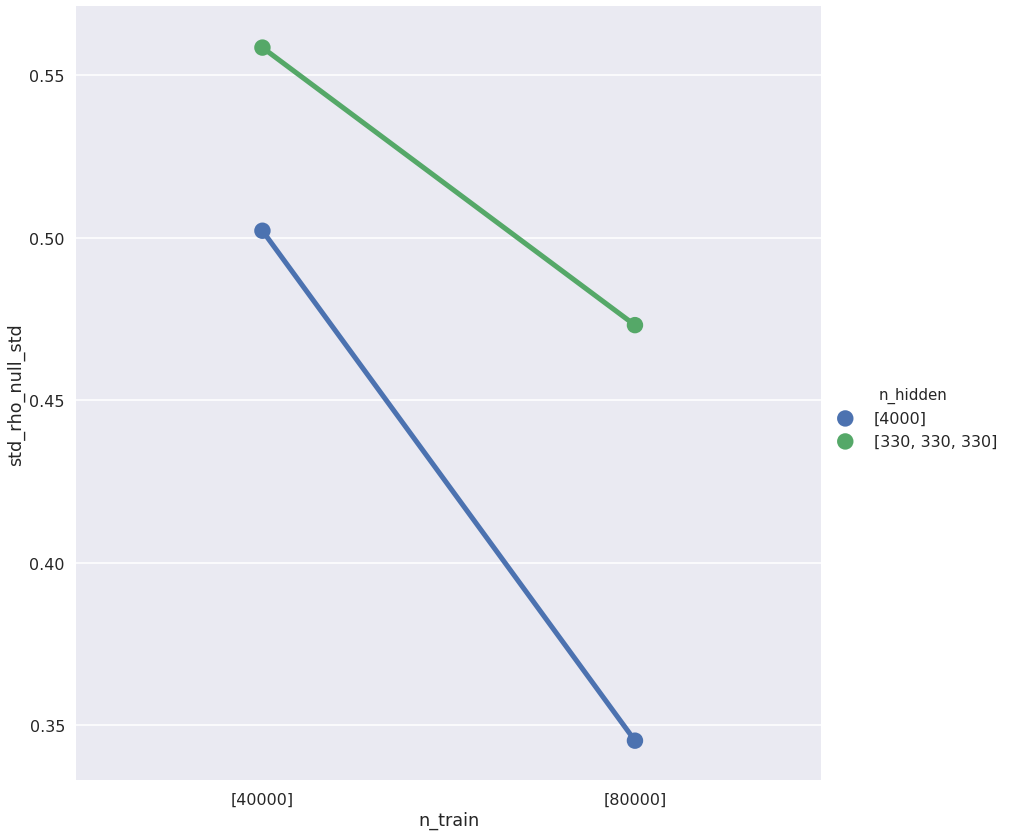

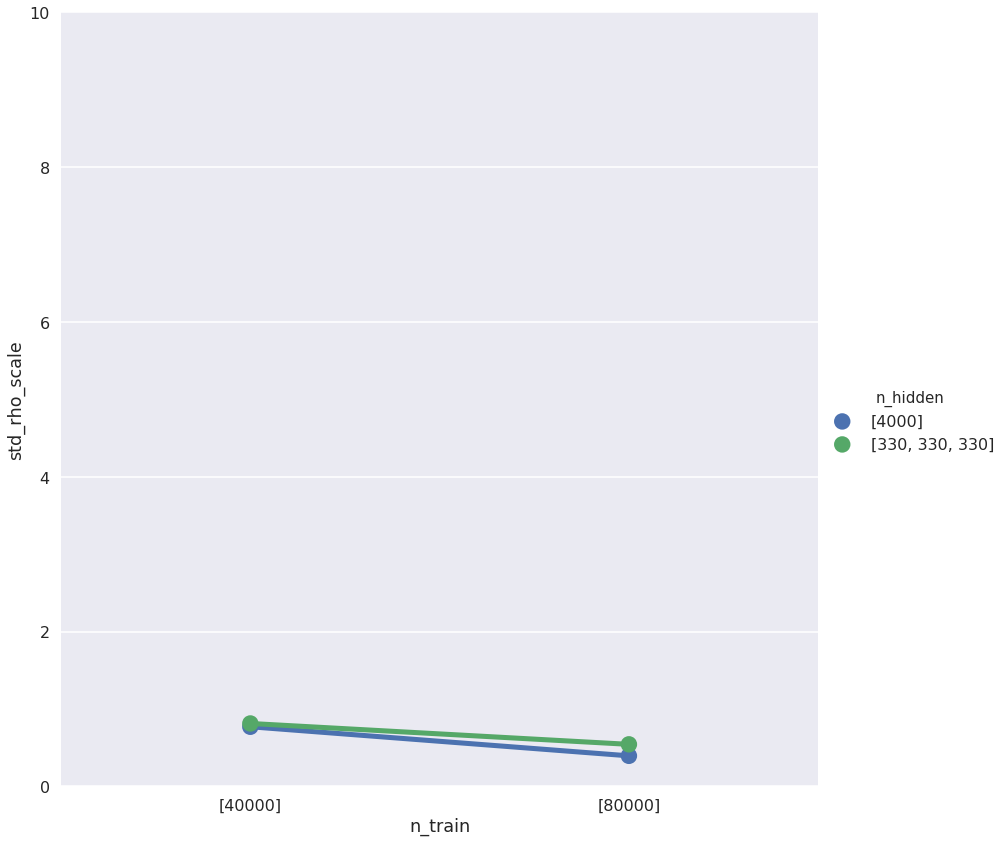

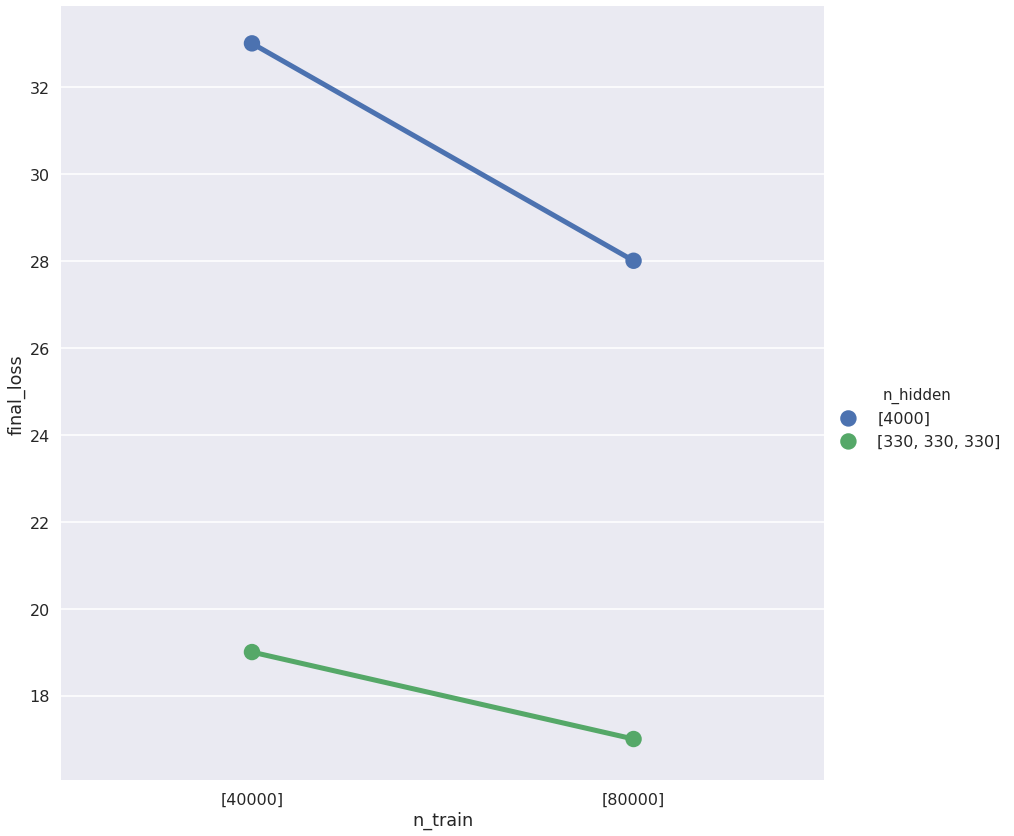

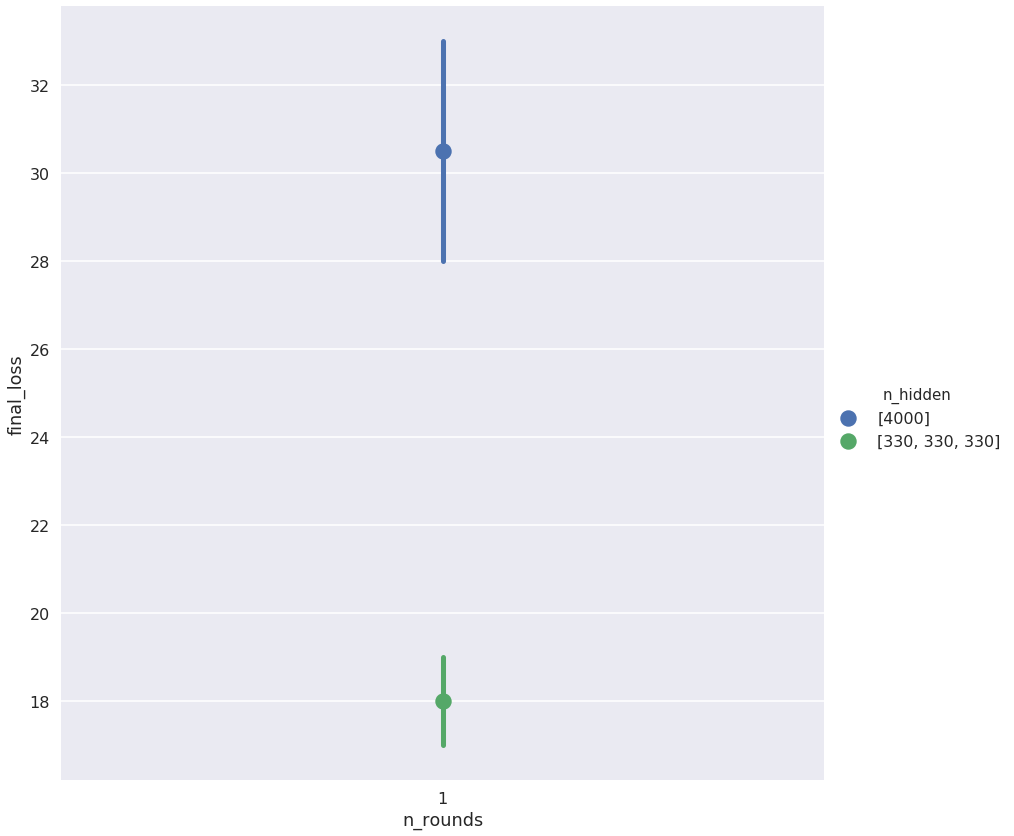

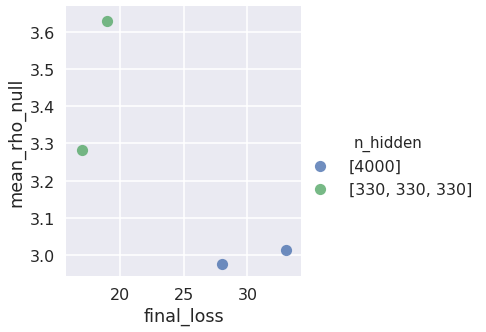

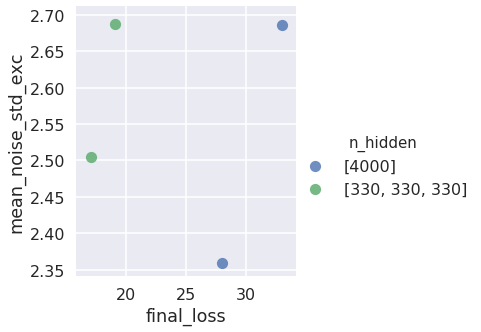

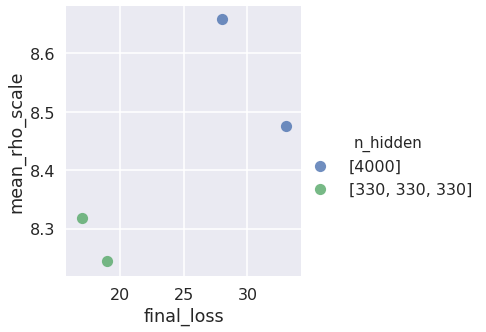

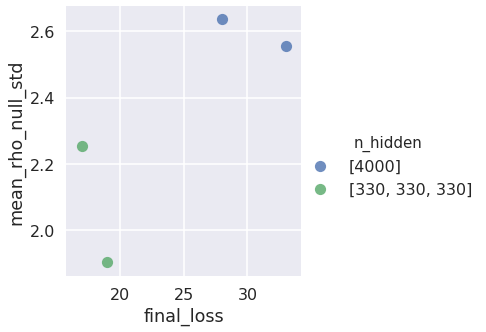

In [67]:
sns.set('poster')
sns.factorplot(x='n_train', y='mean_rho_scale', hue='n_hidden', kind='point', data=meta_df, size=12)
sns.factorplot(x='n_train', y='mean_rho_null_std', hue='n_hidden', kind='point', data=meta_df, size=12)
sns.factorplot(x='n_train', y='std_rho_null_std', hue='n_hidden', kind='point', data=meta_df, size=12)
sns.factorplot(x='n_train', y='std_rho_scale', hue='n_hidden', kind='point', data=meta_df, size=12)
plt.ylim([0,10])
grid = sns.factorplot(x='n_train', y='final_loss', hue='n_hidden', kind='point', data=meta_df, size=12)
grid = sns.factorplot(x='n_rounds', y='final_loss', hue='n_hidden', kind='point', data=meta_df, size=12)
#grid.set(yscale='log')
grid = sns.lmplot(x='final_loss', y='mean_rho_null', hue='n_hidden', fit_reg=False, data=meta_df)
grid = sns.lmplot(x='final_loss', y='mean_noise_std_exc', hue='n_hidden', fit_reg=False, data=meta_df)
grid = sns.lmplot(x='final_loss', y='mean_rho_scale', hue='n_hidden', fit_reg=False, data=meta_df)
grid = sns.lmplot(x='final_loss', y='mean_rho_null_std', hue='n_hidden', fit_reg=False, data=meta_df)

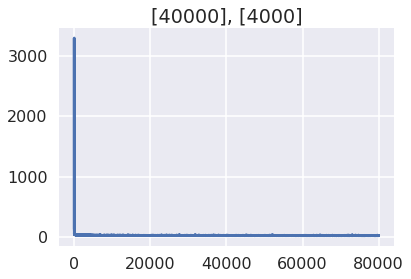

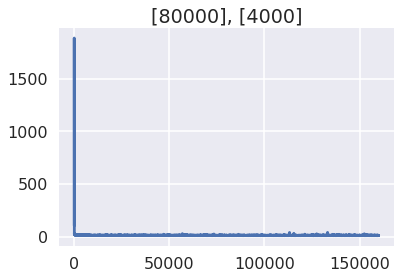

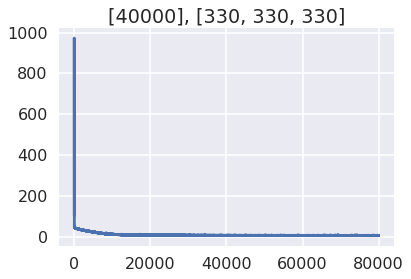

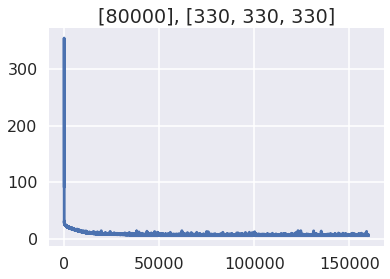

In [68]:
for i in range(len(meta_df)):
    plt.figure()
    plt.plot(meta_df['logs_list'][i][0]['loss'])
    plt.title(str(meta_df['n_train'][i]) + ', ' + str(meta_df['n_hidden'][i]))

In [69]:
gt_array = [true_params['rho_null'][0], true_params['rho_null_std'][0], true_params['noise_std_exc'][0], true_params['rho_scale'][0]]
gt_array

[3.660417457493076, 2.0851013567488494, 3.1968854247268217, 8.261901257817748]

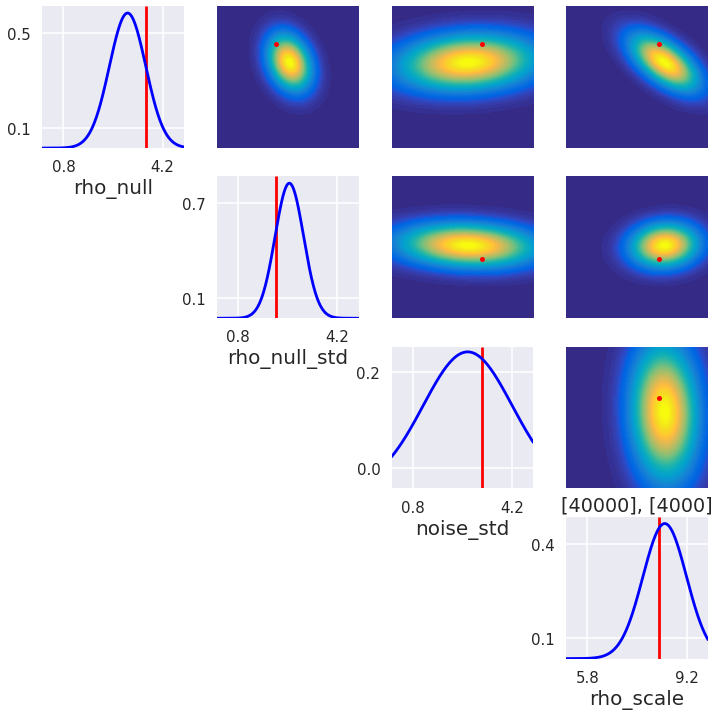

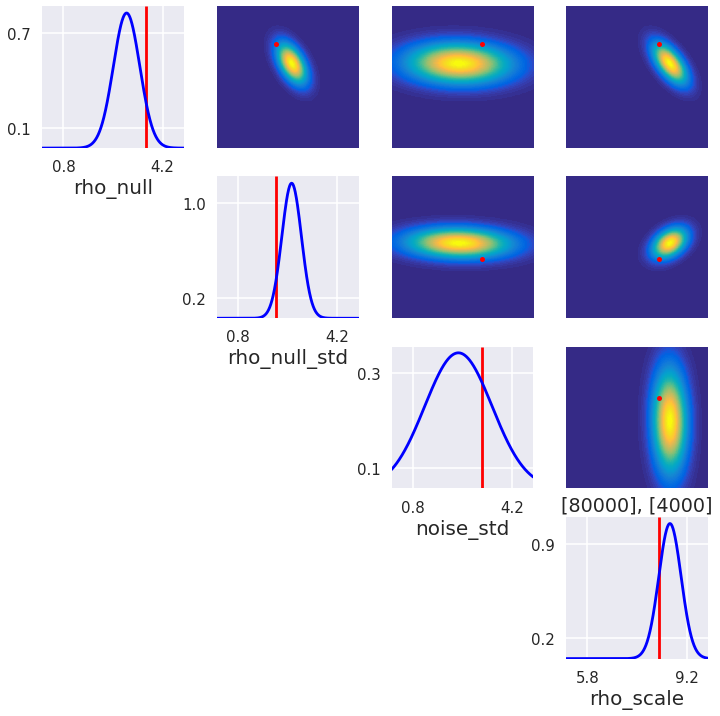

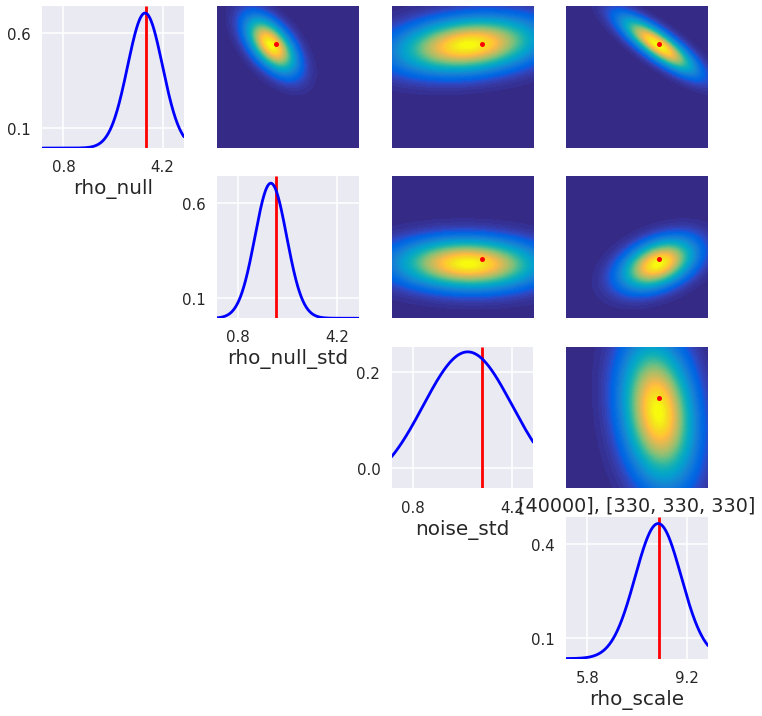

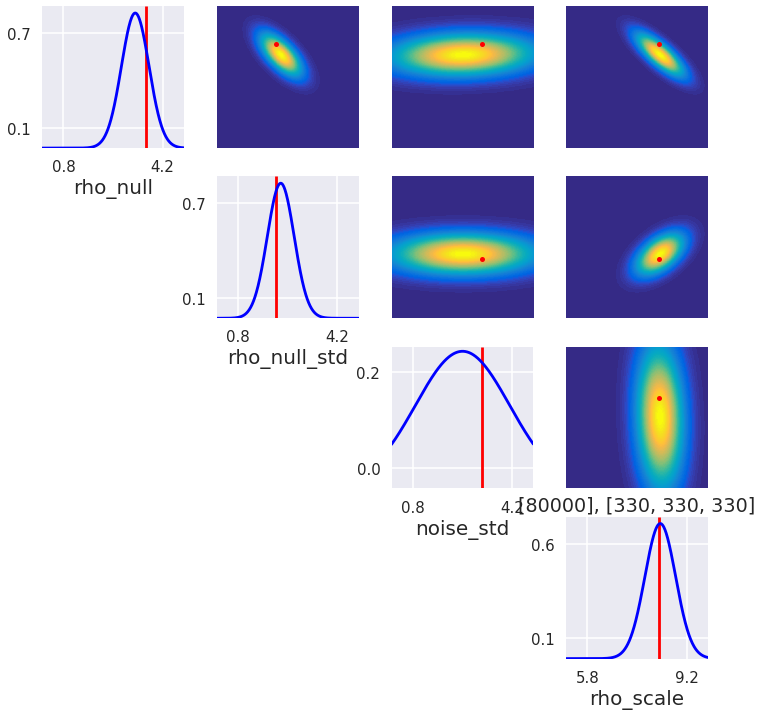

In [70]:
from delfi.utils import viz
sns.set_palette('colorblind')
for i in range(len(meta_df)):
    cpst = meta_df['posterior_object'][i]
    lims = np.array([[0, 5],[0, 5], [0, 5], [5, 10]])
    viz.plot_pdf(cpst.xs[0], lims=lims, labels_params=['rho_null', 'rho_null_std', 'noise_std', 'rho_scale'],
                 gt=gt_array, figsize=(12,12), ticks=True)
    plt.title(str(meta_df['n_train'][i]) + ', ' + str(meta_df['n_hidden'][i]))
    #plt.suptitle(str(cpst.mean))

In [52]:
from delfi.utils import viz
sns.set_palette('colorblind')
for i in range(len(meta_df)):
    cpst = meta_df['posterior_object'][i]
    print(str(cpst.mean))
    print(str(meta_df['mean_rho_null'][i]))

[3.31467847 3.76208819 2.54230583 7.11838935]
3.3146784662150273
[3.30348468 3.27890125 2.28460306 6.9721481 ]
3.3034846836537564
[3.12186278 3.62279602 2.59660934 7.39447217]
3.121862781505872
[3.43729453 3.24558347 2.77944665 7.19167787]
3.4372945272353257
[2.90103101 3.51795786 2.30079563 6.80073727]
2.9010310139598574
[3.95014339 3.54529216 2.1339823  6.82105384]
3.9501433939081667
[2.34430806 3.41738701 2.19667879 6.97210987]
2.3443080637109883
[3.72721006 3.10880215 2.3044688  6.96494269]
3.7272100620937585
[2.32471218 2.81786078 2.67564412 7.56397747]
2.3247121765311496
[2.91905422 3.63048369 2.68391519 7.01869494]
2.919054224163722


# Fit of experimental data:

In [106]:
expm_fit_df = pd.read_hdf('../data/generated/fitting_expm_data.hdf5', key='fitting_results')

Text(0.5,0,'$\\rho_{0}$')

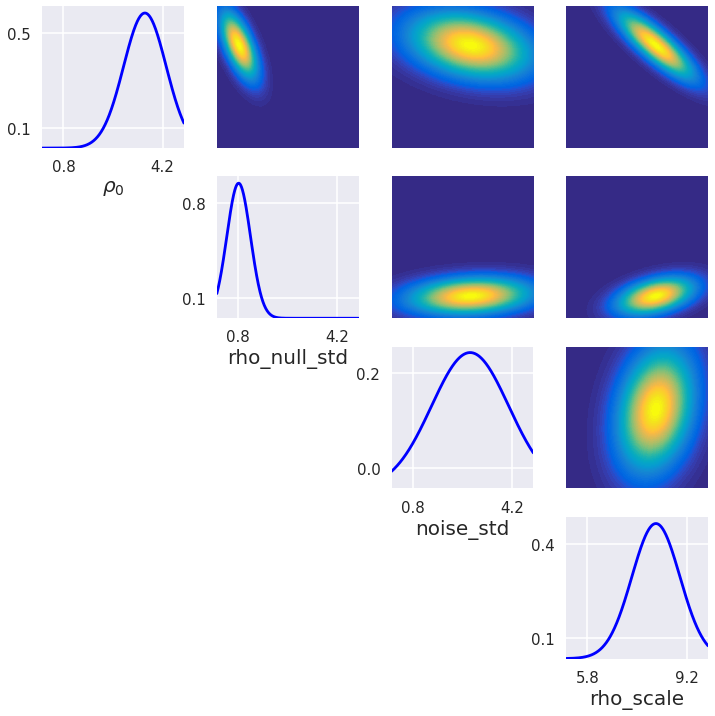

In [114]:
expfit_posterior = expm_fit_df['posterior_object'][0]

lims = np.array([[0, 5],[0, 5], [0, 5], [5, 10]])
fig, axes = viz.plot_pdf(expfit_posterior.xs[0], lims=lims, labels_params=['rho_null', 'rho_null_std', 'noise_std', 'rho_scale'],
                         figsize=(12,12), ticks=True)
axes[0, 0].set_xlabel(r'$\rho_{0}$')

In [110]:
axes.shape

(4, 4)